In [0]:
import numpy as np
import matplotlib.pyplot as plt 
import os

import time
import copy
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

from sklearn import decomposition
import scipy

In [21]:
!pip install torchviz
import torchviz

In [22]:
os.mkdir('/content/PythonCode')
os.chdir('/content/PythonCode/')
!git clone https://github.com/CIA-Oceanix/DinAE_4DVarNN_torch.git


FileExistsError: ignored

In [0]:
os.chdir('/content/PythonCode/DinAE_4DVarNN_torch')
import torch_4DVarNN_dinAE as NN_4DVar

In [0]:
# mount gdrive
from google.colab import drive
drive.mount('/content/drive')

!ls /content/drive/My\ Drive/ResearchData/patchDataset_OcciputData.nc
import os
os.chdir('/content/drive/My Drive/')
!pwd

# L96 Data simulation

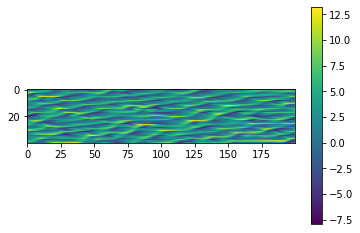

In [24]:
from scipy.integrate import solve_ivp
def AnDA_Lorenz_96(S,t,F,J):
    """ Lorenz-96 dynamical model. """
    x = np.zeros(J);
    x[0] = (S[1]-S[J-2])*S[J-1]-S[0];
    x[1] = (S[2]-S[J-1])*S[0]-S[1];
    x[J-1] = (S[0]-S[J-3])*S[J-2]-S[J-1];
    for j in range(2,J-1):
        x[j] = (S[j+1]-S[j-2])*S[j-1]-S[j];
    dS = x.T + F;
    return dS


class GD:
    model = 'Lorenz_96'
    class parameters:
        F = 8
        J = 40
    dt_integration = 0.05 # integration time
    dt_states = 1 # number of integration times between consecutive states (for xt and catalog)
    dt_obs = 4 # number of integration times between consecutive observations (for yo)
    var_obs = np.random.permutation(parameters.J)[0:20] # indices of the observed variables
    nb_loop_train = 10**4 # size of the catalog
    nb_loop_test = 10 # size of the true state and noisy observations
    sigma2_catalog = 0   # variance of the model error to generate the catalog   
    sigma2_obs = 2 # variance of the observation error to generate observations

class time_series:
  values = 0.
  time   = 0.

# 5 time steps (to be in the attractor space)
GD = GD()    
x0 = GD.parameters.F*np.ones(GD.parameters.J);
x0[np.int(np.around(GD.parameters.J/2))] = x0[np.int(np.around(GD.parameters.J/2))] + 0.01
#S = odeint(AnDA_Lorenz_96,x0,np.arange(0,5+0.000001,GD.dt_integration),args=(GD.parameters.F,GD.parameters.J));
S = solve_ivp(fun=lambda t,y: AnDA_Lorenz_96(y,t,GD.parameters.F,GD.parameters.J),t_span=[0.,5+0.000001],y0=x0,first_step=GD.dt_integration,t_eval=np.arange(0,5+0.000001,GD.dt_integration),method='RK45')
x0 = S.y[:,-1]

# generate true state (xt)
#S = odeint(AnDA_Lorenz_96,x0,np.arange(0.01,GD.nb_loop_test+0.000001,GD.dt_integration),args=(GD.parameters.F,GD.parameters.J));       
tt = np.arange(GD.dt_integration,GD.nb_loop_train*GD.dt_integration+0.000001,GD.dt_integration)
S = solve_ivp(fun=lambda t,y: AnDA_Lorenz_96(y,t,GD.parameters.F,GD.parameters.J),t_span=[GD.dt_integration,GD.nb_loop_train*GD.dt_integration+0.000001],y0=x0,first_step=GD.dt_integration,t_eval=tt,method='RK45')
S = S.y.transpose()

plt.figure(1)
plt.imshow(S[0:200,:].transpose())
plt.colorbar()  
  
xt = time_series()
xt.values = S
xt.time   = tt

# L63 Patch data extraction

In [25]:
from sklearn.feature_extraction import image
            
NbTraining = 2000#2000
NbTest     = 256#256#500
time_step  = 1
dT         = 201
sigNoise   = np.sqrt(2)
rateMissingData = 0.75#0.95
  
xt = time_series()
xt.values = S
xt.time   = tt
# extract subsequences
dataTrainingNoNaN = image.extract_patches_2d(xt.values[0:7000:time_step,:],(dT,GD.parameters.J),NbTraining)
dataTestNoNaN     = image.extract_patches_2d(xt.values[7500::time_step,:],(dT,GD.parameters.J),NbTest)

# create missing data
flagTypeMissData = 1
if flagTypeMissData == 0:
    indRand         = np.random.permutation(dataTrainingNoNaN.shape[0]*dataTrainingNoNaN.shape[1]*dataTrainingNoNaN.shape[2])
    indRand         = indRand[0:int(rateMissingData*len(indRand))]
    dataTraining    = np.copy(dataTrainingNoNaN).reshape((dataTrainingNoNaN.shape[0]*dataTrainingNoNaN.shape[1]*dataTrainingNoNaN.shape[2],1))
    dataTraining[indRand] = float('nan')
    dataTraining    = np.reshape(dataTraining,(dataTrainingNoNaN.shape[0],dataTrainingNoNaN.shape[1],dataTrainingNoNaN.shape[2]))
    
    indRand         = np.random.permutation(dataTestNoNaN.shape[0]*dataTestNoNaN.shape[1]*dataTestNoNaN.shape[2])
    indRand         = indRand[0:int(rateMissingData*len(indRand))]
    dataTest        = np.copy(dataTestNoNaN).reshape((dataTestNoNaN.shape[0]*dataTestNoNaN.shape[1]*dataTestNoNaN.shape[2],1))
    dataTest[indRand] = float('nan')
    dataTest          = np.reshape(dataTest,(dataTestNoNaN.shape[0],dataTestNoNaN.shape[1],dataTestNoNaN.shape[2]))

    genSuffixObs    = '_ObsRnd_%02d_%02d'%(100*rateMissingData,10*sigNoise**2)
else:
    time_step_obs   = int(1./(1.-rateMissingData))
    dataTraining    = np.zeros((dataTrainingNoNaN.shape))
    dataTraining[:] = float('nan')
    dataTest        = np.zeros((dataTestNoNaN.shape))
    dataTest[:]     = float('nan')
    
    if 1*0:
        dataTraining[:,::time_step_obs,:] = dataTrainingNoNaN[:,::time_step_obs,:]
        dataTest[:,::time_step_obs,:]     = dataTestNoNaN[:,::time_step_obs,:]
        
        genSuffixObs    = '_ObsSub_%02d_%02d'%(100*rateMissingData,10*sigNoise**2)
    else:
        for nn in range(0,dataTraining.shape[1],time_step_obs):
            indrand = np.random.permutation(dataTraining.shape[2])[0:int(0.5*dataTraining.shape[2])]
            dataTraining[:,nn,indrand] = dataTrainingNoNaN[:,nn,indrand]

        for nn in range(0,dataTraining.shape[1],time_step_obs):
            indrand = np.random.permutation(dataTraining.shape[2])[0:int(0.5*dataTraining.shape[2])]
            dataTest[:,nn,indrand] = dataTestNoNaN[:,nn,indrand]

        genSuffixObs    = '_ObsSubRnd_%02d_%02d'%(100*rateMissingData,10*sigNoise**2)
    print('... Data type: '+genSuffixObs)
    #for nn in range(0,dataTraining.shape[1],time_step_obs):
    #    dataTraining[:,::time_step_obs,:] = dataTrainingNoNaN[:,::time_step_obs,:]
    
    #dataTest    = np.zeros((dataTestNoNaN.shape))
    #dataTest[:] = float('nan')
    #dataTest[:,::time_step_obs,:] = dataTestNoNaN[:,::time_step_obs,:]

    
# set to NaN patch boundaries
if 1*0:
    dataTraining[:,0:10,:] =  float('nan')
    dataTest[:,0:10,:]     =  float('nan')
    dataTraining[:,dT-10:dT,:] =  float('nan')
    dataTest[:,dT-10:dT,:]     =  float('nan')

# mask for NaN
maskTraining = (dataTraining == dataTraining).astype('float')
maskTest     = ( dataTest    ==  dataTest   ).astype('float')

dataTraining = np.nan_to_num(dataTraining)
dataTest     = np.nan_to_num(dataTest)

# Permutation to have channel as #1 component
dataTraining      = np.moveaxis(dataTraining,-1,1)
maskTraining      = np.moveaxis(maskTraining,-1,1)
dataTrainingNoNaN = np.moveaxis(dataTrainingNoNaN,-1,1)

dataTest      = np.moveaxis(dataTest,-1,1)
maskTest      = np.moveaxis(maskTest,-1,1)
dataTestNoNaN = np.moveaxis(dataTestNoNaN,-1,1)

# set to NaN patch boundaries
#dataTraining[:,0:5,:] =  dataTrainingNoNaN[:,0:5,:]
#dataTest[:,0:5,:]     =  dataTestNoNaN[:,0:5,:]

############################################
## raw data
X_train         = dataTrainingNoNaN
X_train_missing = dataTraining
mask_train      = maskTraining

X_test         = dataTestNoNaN
X_test_missing = dataTest
mask_test      = maskTest

############################################
## normalized data
meanTr          = np.mean(X_train_missing[:]) / np.mean(mask_train) 

x_train_missing = X_train_missing - meanTr
x_test_missing  = X_test_missing - meanTr

# scale wrt std
stdTr           = np.sqrt( np.mean( X_train_missing**2 ) / np.mean(mask_train) )
x_train_missing = x_train_missing / stdTr
x_test_missing  = x_test_missing / stdTr

x_train = (X_train - meanTr) / stdTr
x_test  = (X_test - meanTr) / stdTr


# Generate noisy observsation
X_train_obs = X_train_missing + sigNoise * maskTraining * np.random.randn(X_train_missing.shape[0],X_train_missing.shape[1],X_train_missing.shape[2])
X_test_obs  = X_test_missing  + sigNoise * maskTest * np.random.randn(X_test_missing.shape[0],X_test_missing.shape[1],X_test_missing.shape[2])

x_train_obs = (X_train_obs - meanTr) / stdTr
x_test_obs  = (X_test_obs - meanTr) / stdTr

print('..... Training dataset: %dx%dx%d'%(x_train.shape[0],x_train.shape[1],x_train.shape[2]))
print('..... Test dataset    : %dx%dx%d'%(x_test.shape[0],x_test.shape[1],x_test.shape[2]))


... Data type: _ObsSubRnd_75_20
..... Training dataset: 2000x40x201
..... Test dataset    : 256x40x201


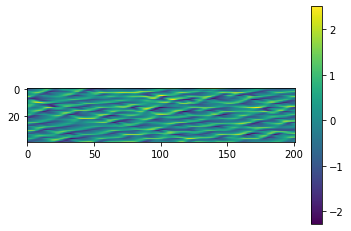

In [26]:
idx = 180

# Visualisation
plt.figure(1)
plt.imshow(x_train[idx,:,:].squeeze())
plt.colorbar()  

# PCA Decomposition & AE architecture

In [0]:
DimAE      = 20#50

In [28]:
# PCA decomposition
pca              = decomposition.PCA(DimAE)
pca.fit(np.reshape(x_train,(x_train.shape[0],x_train.shape[1]*x_train.shape[2])))

rec_PCA_Tt       = pca.transform(np.reshape(x_test,(x_test.shape[0],x_test.shape[1]*x_test.shape[2])))
rec_PCA_Tt[:,DimAE:] = 0.
rec_PCA_Tt       = pca.inverse_transform(rec_PCA_Tt)
mse_PCA_Tt       = np.mean( (rec_PCA_Tt - x_test.reshape((x_test.shape[0],x_test.shape[1]*x_test.shape[2])))**2 )
var_Tt           = np.mean( (x_test-np.mean(x_train,axis=0))** 2 )
exp_var_PCA_Tt   = 1. - mse_PCA_Tt / var_Tt

print(".......... PCA Dim = %d"%(DimAE))
print('.... explained variance PCA (Tr) : %.2f%%'%(100.*np.cumsum(pca.explained_variance_ratio_)[DimAE-1]))
print('.... explained variance PCA (Tt) : %.2f%%'%(100.*exp_var_PCA_Tt))

# visualize PCs and associated projection
PC              = np.zeros((DimAE+1,x_test.shape[1]*x_test.shape[2])) * float('NaN')                        
PC[1:DimAE+1,:] = pca.components_
PC[0,:]         = pca.mean_
PC              = np.reshape(PC,(DimAE+1,x_test.shape[1],x_test.shape[2]))

.......... PCA Dim = 20
.... explained variance PCA (Tr) : 26.45%
.... explained variance PCA (Tt) : 20.68%


In [29]:
shapeData = np.ones(3).astype(int)
shapeData[1:] =  x_train.shape[1:]
# freeze all ode parameters

flagAEType = 0
if flagAEType == -1: ## AE using ode_L63

    class Encoder(torch.nn.Module):
        def __init__(self):
              super(Encoder, self).__init__()
              self.F         = torch.nn.Parameter(torch.Tensor([8.]))
              self.dt        = 0.05
              self.IntScheme = 0
              self.stdTr     = stdTr
              self.meanTr    = meanTr
              #self.conv1     = torch.nn.Conv2d(1,shapeData[0],1,padding=0,bias=False)
            
        def _odeL96(self, xin):
            dx  = (xin[:,:,3:,:]-xin[:,:,0:xin.size(2)-3,:]) * xin[:,:,1:xin.size(2)-2,:] - xin[:,:,2:xin.size(2)-1,:]
            dx0 = (xin[:,:,1,:]-xin[:,:,xin.size(2)-2,:]) * xin[:,:,xin.size(2)-1,:] - xin[:,:,0,:]
            dx1 = (xin[:,:,2,:]-xin[:,:,xin.size(2)-1,:]) * xin[:,:,0,:] - xin[:,:,1,:]
            dxL = (xin[:,:,0,:]-xin[:,:,xin.size(2)-3,:]) * xin[:,:,xin.size(2)-2,:] - xin[:,:,xin.size(2)-1,:]
                            
            dx0 = dx0.view(-1,1,1,xin.size(3))
            dx1 = dx1.view(-1,1,1,xin.size(3))
            dxL = dxL.view(-1,1,1,xin.size(3))
            #print(dx.size())
            #print(dx0.size())
            #print(dx1.size())
            #print(dxL.size())
            dpred = torch.cat((dx0,dx1,dx,dxL),dim=2) + self.F
            return dpred

        def _EulerSolver(self, x):
            return x + self.dt * self._odeL96(x)

        def _RK4Solver(self, x):
            k1 = self._odeL96(x)
            x2 = x + 0.5 * self.dt * k1
            k2 = self._odeL96(x2)
          
            x3 = x + 0.5 * self.dt * k2
            k3 = self._odeL96(x3)
              
            x4 = x + self.dt * k3
            k4 = self._odeL96(x4)

            return x + self.dt * (k1+2.*k2+2.*k3+k4)/6.
      
        def forward(self, x):
            X = self.stdTr * x 
            X = X + self.meanTr
            
            if self.IntScheme == 0:
                xpred = self._EulerSolver( X[:,:,:,0:x.size(3)-1] )
            else:
                xpred = self._RK4Solver( X[:,:,:,0:x.size(3)-1] )

            xpred = xpred - self.meanTr
            xpred = xpred / self.stdTr

            xnew  = torch.cat((x[:,:,:,0].view(-1,1,x.size(2),1),xpred),dim=3)
            return xnew

    class Decoder(torch.nn.Module):
      def __init__(self):
          super(Decoder, self).__init__()

      def forward(self, x):
          return torch.mul(1.,x)
    
    genSuffixModel = '_DinAE4DVar_MLP'  
    modelTemp      = Encoder()
    if modelTemp.IntScheme == 0 :
        genSuffixModel = genSuffixModel+'_L96EulerNN'
    elif modelTemp.IntScheme == 1 :
        genSuffixModel = genSuffixModel+'_L96RK4NN'
        
elif flagAEType == 0: ## AE using ode_L96 (conv2d implementation)

    class Encoder(torch.nn.Module):
        def __init__(self):
              super(Encoder, self).__init__()
              self.F         = torch.nn.Parameter(torch.Tensor([8.]))
              self.dt        = 0.05
              self.IntScheme = 1
              self.stdTr     = stdTr
              self.meanTr    = meanTr
              #self.conv1     = torch.nn.Conv2d(1,shapeData[0],1,padding=0,bias=False)
            
              self.conv1     = torch.nn.Conv2d(1,1,(5,1),padding=0,bias=False)
              self.conv2     = torch.nn.Conv2d(1,1,(3,1),padding=0,bias=False)

              # predefined parameters
              K = torch.Tensor([-1.,0.,0.,1.,0.]).view(1,1,5,1)
              self.conv1.weight = torch.nn.Parameter(K)
              K = torch.Tensor([1.,0.,0.]).view(1,1,3,1)
              self.conv2.weight = torch.nn.Parameter(K)

        def _odeL96(self, xin):
            x_1 = torch.cat((xin[:,:,xin.size(2)-2:,:],xin,xin[:,:,0:2,:]),dim=2)
            #x_1 = x_1.view(-1,1,xin.size(1)+4,xin.size(2))
            x_1 = self.conv1( x_1 )                
            #x_1 = x_1.view(-1,xin.size(1),xin.size(2))

            x_2 = torch.cat((xin[:,:,xin.size(2)-1:,:],xin,xin[:,:,0:1,:]),dim=2)
            #x_2 = x_2.view(-1,1,xin.size(1)+2,xin.size(2))
            x_2 = self.conv2( x_2 )
            #x_2 = x_2.view(-1,xin.size(1),xin.size(2))
                    
            dpred = x_1 * x_2 - xin + self.F
    
            return dpred.view(-1,xin.size(1),xin.size(2),xin.size(3))

        def _EulerSolver(self, x):
            return x + self.dt * self._odeL96(x)

        def _RK4Solver(self, x):
            k1 = self._odeL96(x)
            x2 = x + 0.5 * self.dt * k1
            k2 = self._odeL96(x2)
          
            x3 = x + 0.5 * self.dt * k2
            k3 = self._odeL96(x3)
              
            x4 = x + self.dt * k3
            k4 = self._odeL96(x4)

            return x + self.dt * (k1+2.*k2+2.*k3+k4)/6.
      
        def forward(self, x):
            X = self.stdTr * x 
            X = X + self.meanTr
            
            if self.IntScheme == 0:
                xpred = self._EulerSolver( X[:,:,:,0:x.size(3)-1] )
            else:
                xpred = self._RK4Solver( X[:,:,:,0:x.size(3)-1] )

            xpred = xpred - self.meanTr
            xpred = xpred / self.stdTr

            xnew  = torch.cat((x[:,:,:,0].view(-1,1,x.size(2),1),xpred),dim=3)
            return xnew

    class Decoder(torch.nn.Module):
      def __init__(self):
          super(Decoder, self).__init__()

      def forward(self, x):
          return torch.mul(1.,x)

    genSuffixModel = '_DinAE4DVarv1'  
    modelTemp      = Encoder()
    if modelTemp.IntScheme == 0 :
        genSuffixModel = genSuffixModel+'_L96EulerNN'
    elif modelTemp.IntScheme == 1 :
        genSuffixModel = genSuffixModel+'_L96RK4NN'
        
elif flagAEType == 1: ## Conv model with no use of the central point
  dW = 2
  genSuffixModel = '_GENN_%d_%02d_%02d'%(flagAEType,DimAE,dW)
  class Encoder(torch.nn.Module):
      def __init__(self):
          super(Encoder, self).__init__()
          self.conv1  = NN_4DVar.ConstrainedConv2d(1,DimAE,(2*dW+1,2*dW+1),padding=dW,bias=False)                      
          self.conv21 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv22 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv23 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv3  = torch.nn.Conv2d(2*DimAE,1,(1,1),padding=0,bias=False)
          #self.conv4 = torch.nn.Conv1d(4*shapeData[0]*DimAE,8*shapeData[0]*DimAE,1,padding=0,bias=False)

          #self.conv2Tr = torch.nn.ConvTranspose1d(4*shapeData[0]*DimAE,8*shapeData[0]*DimAE,4,stride=4,bias=False)          
          #self.conv5 = torch.nn.Conv1d(8*shapeData[0]*DimAE,16*shapeData[0]*DimAE,3,padding=1,bias=False)
          #self.conv6 = torch.nn.Conv1d(16*shapeData[0]*DimAE,shapeData[0],3,padding=1,bias=False)

      def forward(self, xin):
          x_1 = torch.cat((xin[:,:,xin.size(2)-dW:,:],xin,xin[:,:,0:dW,:]),dim=2)
          #x_1 = x_1.view(-1,1,xin.size(1)+2*dW,xin.size(2))
          x   = self.conv1( x_1 )
          x   = x[:,:,dW:xin.size(2)+dW,:]
          x   = torch.cat((self.conv21(x), self.conv22(x) * self.conv23(x)),dim=1)
          x   = self.conv3( x )
          #x = self.conv4( F.relu(x) )
          x = x.view(-1,shapeData[0],shapeData[1],shapeData[2])
          return x
  class Decoder(torch.nn.Module):
      def __init__(self):
          super(Decoder, self).__init__()

      def forward(self, x):
          return torch.mul(1.,x)
elif flagAEType == 2: ## Conv model with no use of the central point
  dW = 5
  genSuffixModel = '_GENN_%d_%02d_%02d'%(flagAEType,DimAE,dW)
  class Encoder(torch.nn.Module):
      def __init__(self):
          super(Encoder, self).__init__()
          self.pool1  = torch.nn.AvgPool2d((1,4))
          self.conv11 = NN_4DVar.ConstrainedConv2d(1,DimAE,(2*dW+1,2*dW+1),padding=dW,bias=False)                      
          self.conv12 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv21 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv22 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv23 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv3  = torch.nn.Conv2d(2*DimAE,DimAE,(1,1),padding=0,bias=False)

          self.convTr = torch.nn.ConvTranspose2d(DimAE,DimAE,(1,4),stride=(1,4),bias=False)          
          #self.conv5 = torch.nn.Conv1d(8*shapeData[0]*DimAE,16*shapeData[0]*DimAE,3,padding=1,bias=False)
          #self.conv6 = torch.nn.Conv1d(16*shapeData[0]*DimAE,shapeData[0],3,padding=1,bias=False)
          self.conv11_1 = NN_4DVar.ConstrainedConv2d(1,DimAE,(2*dW+1,2*dW+1),padding=dW,bias=False)                      
          self.conv12_1 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv21_1 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv22_1 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv23_1 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv3_1  = torch.nn.Conv2d(2*DimAE,DimAE,(1,1),padding=0,bias=False)

          self.convF    = torch.nn.Conv2d(DimAE,1,1,padding=0,bias=False)
      def forward(self, xin):
          x_1 = self.pool1(xin)
          x_1 = torch.cat((x_1[:,:,x_1.size(2)-dW:,:],x_1,x_1[:,:,0:dW,:]),dim=2)
          #x_1 = x_1.view(-1,1,xin.size(1)+2*dW,xin.size(2))
          x   = self.conv11( x_1 )
          x   = self.conv12( F.relu(x) )
          x   = x[:,:,dW:xin.size(2)+dW,:]
          x   = torch.cat((self.conv21(x), self.conv22(x) * self.conv23(x)),dim=1)
          x   = self.conv3( x )
          x   = self.convTr( x )
          
          x_2 = torch.cat((xin[:,:,xin.size(2)-dW:,:],xin,xin[:,:,0:dW,:]),dim=2)
          dx  = self.conv11_1( x_2 )
          dx  = self.conv12_1( F.relu(dx) )
          dx   = dx[:,:,dW:xin.size(2)+dW,:]
          dx   = torch.cat((self.conv21_1(dx), self.conv22_1(dx) * self.conv23_1(dx)),dim=1)
          dx   = self.conv3_1( dx )
          
          x    = self.convF( x + dx )
          #x = self.conv4( F.relu(x) )
          x = x.view(-1,shapeData[0],shapeData[1],shapeData[2])
          return x
  class Decoder(torch.nn.Module):
      def __init__(self):
          super(Decoder, self).__init__()

      def forward(self, x):
          return torch.mul(1.,x)
elif flagAEType == 3: ## Conv model with no use of the central point
  dW = 2
  genSuffixModel = '_GENN_%d_%02d_%02d'%(flagAEType,DimAE,dW)
  class Encoder(torch.nn.Module):
      def __init__(self):
          super(Encoder, self).__init__()
          self.pool1  = torch.nn.AvgPool2d((1,4))
          self.conv1  = NN_4DVar.ConstrainedConv2d(1,DimAE,(2*dW+1,2*dW+1),padding=dW,bias=False)                      
          self.conv21 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv22 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv23 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv3  = torch.nn.Conv2d(2*DimAE,4*DimAE,(1,1),padding=0,bias=False)
          self.conv3  = torch.nn.Conv2d(4*DimAE,DimAE,(1,1),padding=0,bias=False)

          self.conv2Tr = torch.nn.ConvTranspose2d(DimAE,DimAE,(1,4),stride=(1,4),bias=False)          
          #self.conv5 = torch.nn.Conv2d(2*DimAE,2*DimAE,(3,3),padding=1,bias=False)
          self.conv6 = torch.nn.Conv2d(DimAE,1,(1,1),padding=0,bias=False)
          #self.conv6 = torch.nn.Conv1d(16*shapeData[0]*DimAE,shapeData[0],3,padding=1,bias=False)

      def forward(self, xin):
          x_1 = torch.cat((xin[:,:,xin.size(2)-dW:,:],xin,xin[:,:,0:dW,:]),dim=2)
          
          x   = self.pool1( x_1 )
          x   = self.conv1( x )
          x   = x[:,:,dW:xin.size(1)+dW,:]
          x   = torch.cat((self.conv21(x), self.conv22(x) * self.conv23(x)),dim=1)
          x   = self.conv3( x )                      
          x   = self.conv4( F.relu(x) )
          x   = self.conv2Tr( x )
          x   = self.conv6( F.relu(x) )                      
          
          return x
  class Decoder(torch.nn.Module):
      def __init__(self):
          super(Decoder, self).__init__()

      def forward(self, x):
          return torch.mul(1.,x)

elif flagAEType == 4: ## Conv model with no use of the central point
  dW = 5
  genSuffixModel = '_GENN_%d_%02d_%02d'%(flagAEType,DimAE,dW)
  class Encoder(torch.nn.Module):
      def __init__(self):
          super(Encoder, self).__init__()
          self.pool1  = torch.nn.AvgPool2d(4)
          self.conv1  = NN_4DVar.ConstrainedConv2d(1,2*DimAE,(2*dW+1,2*dW+1),padding=dW,bias=False)
          self.conv2  = torch.nn.Conv1d(2*DimAE,DimAE,(1,1),padding=0,bias=False)
          
          self.conv21 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv22 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv23 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv3  = torch.nn.Conv2d(2*DimAE,DimAE,(1,1),padding=0,bias=False)
          #self.conv4 = torch.nn.Conv1d(4*shapeData[0]*DimAE,8*shapeData[0]*DimAE,1,padding=0,bias=False)

          self.conv2Tr = torch.nn.ConvTranspose2d(DimAE,1,(4,4),stride=(4,4),bias=False)          
          #self.conv5 = torch.nn.Conv1d(2*shapeData[0]*DimAE,2*shapeData[0]*DimAE,3,padding=1,bias=False)
          #self.conv6 = torch.nn.Conv1d(2*shapeData[0]*DimAE,shapeData[0],1,padding=0,bias=False)
          #self.conv6 = torch.nn.Conv1d(16*shapeData[0]*DimAE,shapeData[0],3,padding=1,bias=False)

          self.convHR1  = NN_4DVar.ConstrainedConv2d(1,2*DimAE,(2*dW+1,2*dW+1),padding=dW,bias=False)
          self.convHR2  = torch.nn.Conv2d(2*DimAE,DimAE,(1,1),padding=0,bias=False)
          
          self.convHR21 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.convHR22 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.convHR23 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.convHR3  = torch.nn.Conv2d(2*DimAE,1,(1,1),padding=0,bias=False)

      def forward(self, xinp):
          #x = self.fc1( torch.nn.Flatten(x) )
          #x = self.pool1( xinp )
          x = self.pool1( xinp )
          x = self.conv1( x )
          x = self.conv2( F.relu(x) )
          x = torch.cat((self.conv21(x), self.conv22(x) * self.conv23(x)),dim=1)
          x = self.conv3( x )
          x = self.conv2Tr( x )
          #x = self.conv5( F.relu(x) )
          #x = self.conv6( F.relu(x) )
          
          xHR = self.convHR1( xinp )
          xHR = self.convHR2( F.relu(xHR) )
          xHR = torch.cat((self.convHR21(xHR), self.convHR22(xHR) * self.convHR23(xHR)),dim=1)
          xHR = self.convHR3( xHR )
          
          x   = torch.add(x,1.,xHR)
          
          #x = x.view(-1,shapeData[0],shapeData[1],shapeData[2])
          return x

  class Decoder(torch.nn.Module):
      def __init__(self):
          super(Decoder, self).__init__()

      def forward(self, x):
          return torch.mul(1.,x)

class Model_AE(torch.nn.Module):
    def __init__(self):
        super(Model_AE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder( x )
        x = self.decoder( x )
        return x

model_AE           = Model_AE()
print('AE Model type: '+genSuffixModel)
print(model_AE)
print('Number of trainable parameters = %d'%(sum(p.numel() for p in model_AE.parameters() if p.requires_grad)))


AE Model type: _DinAE4DVarv1_L96RK4NN
Model_AE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 1, kernel_size=(5, 1), stride=(1, 1), bias=False)
    (conv2): Conv2d(1, 1, kernel_size=(3, 1), stride=(1, 1), bias=False)
  )
  (decoder): Decoder()
)
Number of trainable parameters = 9


torch.Size([21, 1, 3, 200])


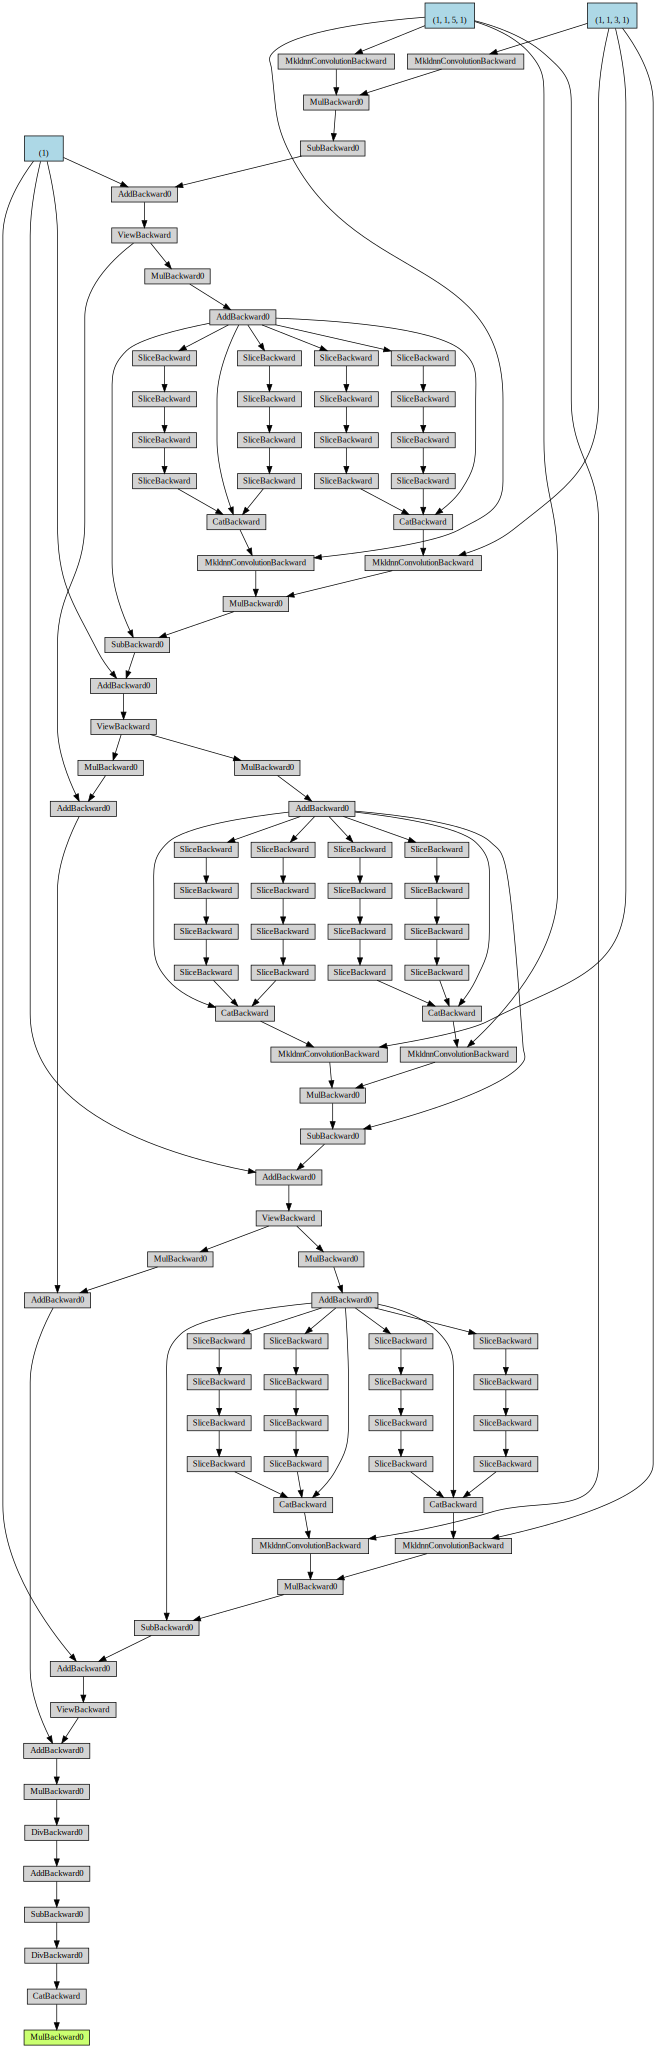

In [30]:
#Model visualisation
inputs = torch.randn(21,1,3,200)
y = model_AE(torch.autograd.Variable(inputs))
print(y.size())
torchviz.make_dot(y)

# Initial interpolation (linear interpolation)

In [31]:
print('........ Initialize interpolated states')

# Initialization for interpolation
flagInit = 1

if flagInit == 0: 
  X_train_Init = mask_train * X_train_obs + (1. - mask_train) * (np.zeros(X_train_missing.shape) + meanTr)
  X_test_Init  = mask_test * X_test_obs + (1. - mask_test) * (np.zeros(X_test_missing.shape) + meanTr)
else:
  X_train_Init = np.zeros(X_train.shape)
  for ii in range(0,X_train.shape[0]):
    # Initial linear interpolation for each component
    XInit = np.zeros((X_train.shape[1],X_train.shape[2]))

    for kk in range(0,mask_train.shape[1]):
      indt  = np.where( mask_train[ii,kk,:] == 1.0 )[0]
      indt_ = np.where( mask_train[ii,kk,:] == 0.0 )[0]

      if len(indt) > 1:
        indt_[ np.where( indt_ < np.min(indt)) ] = np.min(indt)
        indt_[ np.where( indt_ > np.max(indt)) ] = np.max(indt)
        fkk = scipy.interpolate.interp1d(indt, X_train_obs[ii,kk,indt])
        XInit[kk,indt]  = X_train_obs[ii,kk,indt]
        XInit[kk,indt_] = fkk(indt_)
      else:
        XInit = XInit + meanTr

    X_train_Init[ii,:,:] = XInit

  X_test_Init = np.zeros(X_test.shape)
  for ii in range(0,X_test.shape[0]):
    # Initial linear interpolation for each component
    XInit = np.zeros((X_test.shape[1],X_test.shape[2]))

    for kk in range(0,X_test.shape[1]):
      indt  = np.where( mask_test[ii,kk,:] == 1.0 )[0]
      indt_ = np.where( mask_test[ii,kk,:] == 0.0 )[0]

      if len(indt) > 1:
        indt_[ np.where( indt_ < np.min(indt)) ] = np.min(indt)
        indt_[ np.where( indt_ > np.max(indt)) ] = np.max(indt)
        fkk = scipy.interpolate.interp1d(indt, X_test_obs[ii,kk,indt])
        XInit[kk,indt]  = X_test_obs[ii,kk,indt]
        XInit[kk,indt_] = fkk(indt_)
      else:
        XInit = XInit + meanTr

    X_test_Init[ii,:,:] = XInit
      #plt.figure()
      #plt.figure()
      #plt.plot(YObs[0:200,1],'r.')
      #plt.plot(XGT[0:200,1],'b-')
      #plt.plot(XInit[0:200,1],'k-')
            
x_train_Init = ( X_train_Init - meanTr ) / stdTr
x_test_Init = ( X_test_Init - meanTr ) / stdTr


# reshape to dT-1 for time dimension
dT = dT-1
X_train_obs        = X_train_obs[:,:,0:dT]
X_train            = X_train[:,:,0:dT]
X_train_missing    = X_train_missing[:,:,0:dT]
mask_train         = mask_train[:,:,0:dT]

x_train_obs        = x_train_obs[:,:,0:dT]
x_train            = x_train[:,:,0:dT]
x_train_Init       = x_train_Init[:,:,0:dT]
X_train_Init       = X_train_Init[:,:,0:dT]

X_test_obs        = X_test_obs[:,:,0:dT]
X_test            = X_test[:,:,0:dT]
X_test_missing    = X_test_missing[:,:,0:dT]
mask_test         = mask_test[:,:,0:dT]

x_test_obs        = x_test_obs[:,:,0:dT]
x_test            = x_test[:,:,0:dT]
x_test_Init       = x_test_Init[:,:,0:dT]
X_test_Init       = X_test_Init[:,:,0:dT]

print('..... Training dataset: %dx%dx%d'%(x_train.shape[0],x_train.shape[1],x_train.shape[2]))
print('..... Test dataset    : %dx%dx%d'%(x_test.shape[0],x_test.shape[1],x_test.shape[2]))


........ Initialize interpolated states
..... Training dataset: 2000x40x200
..... Test dataset    : 256x40x200


# Learning AE model

In [0]:
batch_size = 64

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AE           = model_AE.to(device)

# mean-squared error loss
#criterion = torch.nn.MSELoss()
var_Tr    = np.var( x_train )
var_Tt    = np.var( x_test )

#### Check AE performance 
optimizer_AE       = optim.Adam(model_AE.parameters(), lr=1e-3)
exp_lr_schedulerAE = lr_scheduler.StepLR(optimizer_AE, step_size=100, gamma=0.1)

training_dataset     = torch.utils.data.TensorDataset(torch.Tensor(x_train_missing),torch.Tensor(x_train_obs),torch.Tensor(mask_train),torch.Tensor(x_train)) # create your datset
test_dataset         = torch.utils.data.TensorDataset(torch.Tensor(x_test_missing),torch.Tensor(x_test_obs),torch.Tensor(mask_test),torch.Tensor(x_test)) # create your datset

dataloaders = {
    'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
    'val': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
}

dataset_sizes = {'train': len(training_dataset), 'val': len(test_dataset)}

# training function for dinAE



In [0]:
since = time.time()

best_model_AE_wts = copy.deepcopy(model_AE.state_dict())
best_loss         = 1e10

num_epochs = 20
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
          model_AE.train()
        else:
          model_AE.eval()   # Set model to evaluate mode

        running_loss = 0.0
        num_loss     = 0

        # Iterate over data.
        #for inputs_ in dataloaders[phase]:
        #    inputs = inputs_[0].to(device)
        for inputs_init,inputs_missing,masks,targets_GT in dataloaders[phase]:
            targets_GT     = targets_GT.to(device)
            #print(inputs.size(0))

            # zero the parameter gradients
            optimizer_AE.zero_grad()

            # reshaping tensors
            targets_GT     = targets_GT.view(-1,1,targets_GT.size(1),targets_GT.size(2))

            # forward
            # need to evaluate grad/backward during the evaluation and training phase for model_AE
            with torch.set_grad_enabled(True): 
            #with torch.set_grad_enabled(phase == 'train'):
                outputs = model_AE(targets_GT)
                #outputs = model(inputs)
                #loss = criterion( outputs,  inputs)
                loss      = torch.mean((outputs - targets_GT)**2 )

                # backward + optimize only if in training phase
                if phase == 'train':
                  loss.backward()
                  optimizer_AE.step()

            # statistics
            running_loss             += loss.item() * inputs_missing.size(0)
            num_loss                 += inputs_missing.size(0)
            #running_expvar += torch.sum( (outputs - inputs)**2 ) / torch.sum(
        if phase == 'train':
            exp_lr_schedulerAE.step()

        epoch_loss       = running_loss / num_loss
        #epoch_acc = running_corrects.double() / dataset_sizes[phase]
        if phase == 'train':
          epoch_nloss = epoch_loss / var_Tr
        else:
          epoch_nloss = epoch_loss / var_Tt


        #print('{} Loss: {:.4f} '.format(
          #   phase, epoch_loss))
        print('{} Loss: {:.4e} NLossAll: {:.4e} '.format(
            phase, epoch_loss,epoch_nloss))

        # deep copy the model
        if phase == 'val' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model_AE.state_dict())

    print()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val loss: {:4f}'.format(best_loss))

Epoch 0/19
----------
train Loss: 6.4375e-07 NLossAll: 9.0868e-07 
val Loss: 6.6253e-07 NLossAll: 9.3307e-07 

Epoch 1/19
----------
train Loss: 5.7220e-07 NLossAll: 8.0767e-07 
val Loss: 6.5768e-07 NLossAll: 9.2623e-07 

Epoch 2/19
----------
train Loss: 5.6955e-07 NLossAll: 8.0394e-07 
val Loss: 6.5744e-07 NLossAll: 9.2589e-07 

Epoch 3/19
----------
train Loss: 5.6949e-07 NLossAll: 8.0385e-07 
val Loss: 6.5745e-07 NLossAll: 9.2590e-07 

Epoch 4/19
----------
train Loss: 5.6949e-07 NLossAll: 8.0386e-07 
val Loss: 6.5739e-07 NLossAll: 9.2583e-07 

Epoch 5/19
----------
train Loss: 5.6950e-07 NLossAll: 8.0387e-07 
val Loss: 6.5734e-07 NLossAll: 9.2575e-07 

Epoch 6/19
----------
train Loss: 5.6951e-07 NLossAll: 8.0389e-07 
val Loss: 6.5756e-07 NLossAll: 9.2606e-07 

Epoch 7/19
----------
train Loss: 5.6951e-07 NLossAll: 8.0389e-07 
val Loss: 6.5741e-07 NLossAll: 9.2585e-07 

Epoch 8/19
----------
train Loss: 5.6951e-07 NLossAll: 8.0389e-07 
val Loss: 6.5760e-07 NLossAll: 9.2612e-07 

E

# Learning AE/4DVar model from irregularly-sampled data (DinAE solver vs. gradient-based solver) using a fully groundtruthed dataset

In [32]:
# Force observed values to be maintained to be kept to the
# initial values (noise-free case): InterpFlag = True 
# vs. noisy case InterpFlag = False (default parameter)
InterpFlag = False
UsePriodicBoundary = True

#  use gpu if available
batch_size = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(".... Device GPU: "+str(torch.cuda.is_available()))
print(shapeData.shape)

# mean-squared error loss
#criterion = torch.nn.MSELoss()
var_Tr    = np.var( x_train )
var_Tt    = np.var( x_test )
              
alpha          = np.array([1.,0.1])
GradType       = 1 # Gradient computation (0: subgradient, 1: true gradient/autograd)
OptimType      = 2 # 0: fixed-step gradient descent, 1: ConvNet_step gradient descent, 2: LSTM-based descent
num_epochs     = 4000

IterUpdate     = [0,100,200,500,2000,1000,1200]#[0,2,4,6,9,15]
NbProjection   = [0,0,0,0,0,0,0]#[0,0,0,0,0,0]#[5,5,5,5,5]##
NbGradIter     = [10,10,20,20,20,20,20]#[0,0,1,2,3,3]#[0,2,2,4,5,5]#
lrUpdate       = [1e-3,1e-4,1e-4,1e-5,1e-5,1e-4,1e-5,1e-6,1e-7]

NBGradCurrent   = NbGradIter[0]
NBProjCurrent   = NbProjection[0]
lrCurrent       = lrUpdate[0]

model           = NN_4DVar.Model_4DVarNN_GradFP(model_AE,shapeData,NBProjCurrent,NBGradCurrent,GradType,OptimType,UsePriodicBoundary)        
modelSave       = NN_4DVar.Model_4DVarNN_GradFP(model_AE,shapeData,NBProjCurrent,NBGradCurrent,GradType,OptimType,UsePriodicBoundary) 
model           = model.to(device)
print('4DVar model: Number of trainable parameters = %d'%(sum(p.numel() for p in model.parameters() if p.requires_grad)))
              
flagLoadModel   = 0
#fileAEModelInit = ''
if flagLoadModel == 1:
    print('.... load model: '+fileAEModelInit)
    model.model_AE.load_state_dict(torch.load(fileAEModelInit))
    model.model_Grad.load_state_dict(torch.load(fileAEModelInit.replace('_modelAE_iter','_modelGrad_iter')))

# optimization setting: freeze or not the AE
lambda_LRAE = 0.5
optimizer   = optim.Adam([{'params': model.model_Grad.parameters()},
                        {'params': model.model_AE.encoder.parameters(), 'lr': lambda_LRAE*lrCurrent}
                        ], lr=lrCurrent)

# Create training/test data pytorch tensors and associated  
# list of tensors (xx[n][x] to access the nth sample for the xth field)
training_dataset     = torch.utils.data.TensorDataset(torch.Tensor(x_train_Init),torch.Tensor(x_train_obs),torch.Tensor(mask_train),torch.Tensor(x_train)) # create your datset
test_dataset         = torch.utils.data.TensorDataset(torch.Tensor(x_test_Init),torch.Tensor(x_test_obs),torch.Tensor(mask_test),torch.Tensor(x_test)) # create your datset

dataloaders = {
    'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
    'val': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
}            
dataset_sizes = {'train': len(training_dataset), 'val': len(test_dataset)}

# Suffix for file naming
genSuffixModelBase = genSuffixModel
    
genSuffixModel = genSuffixModelBase+'_DT'+str('%02d'%(time_step))+'_'+str('%03d'%(dT))
genSuffixModel = genSuffixModel+genSuffixObs
if lambda_LRAE == 0. :
      genSuffixModel = genSuffixModel+'_NoFTrAE'
    
genSuffixModel = genSuffixModel+'_Nproj'+str('%02d'%(NBProjCurrent))
genSuffixModel = genSuffixModel+'_Grad_'+str('%02d'%(GradType))+'_'+str('%02d'%(OptimType))+'_'+str('%02d'%(NBGradCurrent))


.... Device GPU: True
(3,)
Opitm type 2
Opitm type 2
4DVar model: Number of trainable parameters = 1117


In [0]:
# training function for dinAE
since = time.time()

alpha_Grad = alpha[0]
alpha_AE   = alpha[1]

best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 1e10

num_epochs  = 3
comptUpdate = 1
iterInit    = 0
for epoch in range(iterInit,num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    if ( epoch == IterUpdate[comptUpdate] ) & ( epoch > 0 ):
        # update GradFP parameters
        NBProjCurrent = NbProjection[comptUpdate]
        NBGradCurrent = NbGradIter[comptUpdate]
        lrCurrent     = lrUpdate[comptUpdate]
        
        if( (NBProjCurrent != NbProjection[comptUpdate-1]) | (NBGradCurrent != NbGradIter[comptUpdate-1]) ):
            print("..... ")
            print("..... ")
            print("..... Update/initialize number of projections/Graditer in GradCOnvAE model # %d/%d"%(NbProjection[comptUpdate],NbGradIter[comptUpdate]))

            # update GradFP architectures
            print('..... Update model architecture')
            print("..... ")
            model = NN_4DVar.Model_4DVarNN_GradFP(model_AE,shapeData,NBProjCurrent,NBGradCurrent,GradType,OptimType,UsePriodicBoundary)        
            model = model.to(device)
            
            # copy model parameters from current model
            model.load_state_dict(best_model_wts)
            
            optimizer        = optim.Adam([{'params': model.model_Grad.parameters()},
                                    {'params': model.model_AE.encoder.parameters(), 'lr': lambda_LRAE*lrCurrent}
                                    ], lr=lrCurrent)

            # Suffix for file naming
            genSuffixModel = genSuffixModelBase+'_DT'+str('%02d'%(time_step))+'_'+str('%03d'%(dT))
            genSuffixModel = genSuffixModel+genSuffixObs
            if lambda_LRAE == 0. :
                  genSuffixModel = genSuffixModel+'_NoFTrAE'
            
            genSuffixModel = genSuffixModel+'_Nproj'+str('%02d'%(NBProjCurrent))
            genSuffixModel = genSuffixModel+'_Grad_'+str('%02d'%(GradType))+'_'+str('%02d'%(OptimType))+'_'+str('%02d'%(NBGradCurrent))

        else:
            # update optimizer learning rate
            print('..... Update learning rate')
            mm = 0
            lr = np.array([lrCurrent,lambda_LRAE*lrCurrent])
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr[mm]
                mm += 1

        # update counter
        if comptUpdate < len(IterUpdate)-1:
            comptUpdate += 1

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:        
        if phase == 'train':
            model.train()
        else:
            model.eval()
        #if phase == 'train':
        #    #rint('Learning')
        #    model.train()  # Set model to training mode
        #else:
        #    #print('Evaluation')
        #    model.eval()   # Set model to evaluate mode

        running_loss         = 0.0
        running_loss_All     = 0.
        running_loss_R       = 0.
        running_loss_I       = 0.
        running_loss_AE      = 0.
        num_loss             = 0

        # Iterate over data.
        #for inputs_ in dataloaders[phase]:
        #    inputs = inputs_[0].to(device)
        for inputs_init,inputs_missing,masks,targets_GT in dataloaders[phase]:
            inputs_init    = inputs_init.to(device)
            inputs_missing = inputs_missing.to(device)
            masks          = masks.to(device)
            targets_GT     = targets_GT.to(device)
            #print(inputs.size(0))


            # reshaping tensors
            inputs_init    = inputs_init.view(-1,1,inputs_init.size(1),inputs_init.size(2))
            inputs_missing = inputs_missing.view(-1,1,inputs_init.size(2),inputs_init.size(3))
            masks          = masks.view(-1,1,inputs_init.size(2),inputs_init.size(3))
            targets_GT     = targets_GT.view(-1,1,inputs_init.size(2),inputs_init.size(3))
                                    
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # need to evaluate grad/backward during the evaluation and training phase for model_AE
            with torch.set_grad_enabled(True): 
            #with torch.set_grad_enabled(phase == 'train'):
                inputs_init    = torch.autograd.Variable(inputs_init, requires_grad=True)
                if model.OptimType == 1:
                    outputs,grad_new,normgrad = model(inputs_init,inputs_missing,masks,None)
                    
                elif model.OptimType == 2:
                    outputs,hidden_new,cell_new,normgrad = model(inputs_init,inputs_missing,masks,None,None)
                    
                else:                               
                    outputs,normgrad = model(inputs_init,inputs_missing,masks)

                #outputs = model(inputs_init,inputs_missing,masks)
                
                loss_R      = torch.sum((outputs - targets_GT)**2 * masks )
                loss_R      = torch.mul(1.0 / torch.sum(masks),loss_R)
                loss_I      = torch.sum((outputs - targets_GT)**2 * (1. - masks) )
                loss_I      = torch.mul(1.0 / torch.sum(1.-masks),loss_I)
                loss_All    = torch.mean((outputs - targets_GT)**2 )
                loss_AE     = torch.mean((model.model_AE(outputs) - outputs)**2 )
                            
                loss_AE_GT  = torch.mean((model.model_AE(targets_GT) - targets_GT)**2 )
                #loss_AE_GT  = torch.mean((mod.model_AE(targets_GT) - targets_GT)**2 )

                loss  = alpha_Grad * loss_All + 0.5 * alpha_AE * ( loss_AE + loss_AE_GT )
                #if phase == 'train':                                 
                #    loss  = alpha_Grad * loss_All + 0.5 * alpha_AE * ( loss_AE + loss_AE_GT )
                #else:
                #    loss    = alpha_Grad * loss_R + alpha_AE * loss_AE

                # backward + optimize only if in training phase
                if( phase == 'train' ):
                    loss.backward()
                    optimizer.step()
                                
                # statistics
            running_loss             += loss.item() * inputs_missing.size(0)
            running_loss_I           += loss_I.item() * inputs_missing.size(0)
            running_loss_R           += loss_R.item() * inputs_missing.size(0)
            running_loss_All         += loss_All.item() * inputs_missing.size(0)
            running_loss_AE          += loss_AE_GT.item() * inputs_missing.size(0)
            num_loss                 += inputs_missing.size(0)

        epoch_loss       = running_loss / num_loss
        epoch_loss_All   = running_loss_All / num_loss
        epoch_loss_AE    = running_loss_AE / num_loss
        epoch_loss_I     = running_loss_I / num_loss
        epoch_loss_R     = running_loss_R / num_loss
        #epoch_acc = running_corrects.double() / dataset_sizes[phase]

        epoch_loss_All = epoch_loss_All * stdTr**2
        epoch_loss_I   = epoch_loss_I * stdTr**2
        epoch_loss_R   = epoch_loss_R * stdTr**2
        epoch_loss_AE  = epoch_loss_AE * stdTr**2

        print('{} Loss: {:.4e} NLossAll: {:.4e} NLossR: {:.4e} NLossI: {:.4e} NLossAE: {:.4e}'.format(
            phase, epoch_loss,epoch_loss_All,epoch_loss_R,epoch_loss_I,epoch_loss_AE),flush=True)
        #print('... F %f'%model.model_AE.encoder.F)
        
        # deep copy the model
        if phase == 'val' and epoch_loss < best_loss:
            best_loss      = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val loss: {:4f}'.format(best_loss))

Epoch 0/2
----------


# Evaluation of trained models

In [0]:


#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(".... Device GPU: "+str(torch.cuda.is_available()))

# mean-squared error loss
#criterion = torch.nn.MSELoss()
var_Tr    = np.var( x_train )
var_Tt    = np.var( x_test )
               
# Create training/test data pytorch tensors and associated  
# list of tensors (xx[n][x] to access the nth sample for the xth field)
training_dataset     = torch.utils.data.TensorDataset(torch.Tensor(x_train_Init),torch.Tensor(x_train_obs),torch.Tensor(mask_train),torch.Tensor(x_train)) # create your datset
test_dataset         = torch.utils.data.TensorDataset(torch.Tensor(x_test_Init),torch.Tensor(x_test_obs),torch.Tensor(mask_test),torch.Tensor(x_test)) # create your datset

dataloaders = {
    'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True),
    'val': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True),
}            
dataset_sizes = {'train': len(training_dataset), 'val': len(test_dataset)}


# training function for dinAE
# Each epoch has a training and validation phase
alpha4DVar = np.array([0.01,0.99])
y_train = np.zeros(x_train.shape)
y_test  = np.zeros(x_test.shape)

for phase in ['train', 'val']:        
    since = time.time()

    model.eval()
    #if phase == 'train':
    #    #rint('Learning')
    #    model.train()  # Set model to training mode
    #else:
    #    #print('Evaluation')
    #    model.eval()   # Set model to evaluate mode

    running_loss_Obs     = 0.0
    running_loss_All     = 0.
    running_loss_R       = 0.
    running_loss_I       = 0.
    running_loss_AE      = 0.
    running_loss_AE_GT   = 0.
    num_loss             = 0

    idx = 0 # counter

    # Iterate over data.
    #for inputs_ in dataloaders[phase]:
    #    inputs = inputs_[0].to(device)
    for inputs_init,inputs_missing,masks,targets_GT in dataloaders[phase]:
        inputs_init    = inputs_init.to(device)
        inputs_missing = inputs_missing.to(device)
        masks          = masks.to(device)
        targets_GT     = targets_GT.to(device)
        #print(inputs_init.size(0))


        # reshaping tensors
        inputs_init    = inputs_init.view(-1,1,inputs_init.size(1),inputs_init.size(2))
        inputs_missing = inputs_missing.view(-1,1,inputs_init.size(2),inputs_init.size(3))
        masks          = masks.view(-1,1,inputs_init.size(2),inputs_init.size(3))
        targets_GT     = targets_GT.view(-1,1,inputs_init.size(2),inputs_init.size(3))
                                
        # forward
        # need to evaluate grad/backward during the evaluation and training phase for model_AE
        with torch.set_grad_enabled(True): 
            #with torch.set_grad_enabled(phase == 'train'):
            inputs_init    = torch.autograd.Variable(inputs_init, requires_grad=True)
            if model.OptimType == 1:
                outputs,grad_new = model(inputs_init,inputs_missing,masks,None)
                
            elif model.OptimType == 2:
                outputs,hidden_new,cell_new = model(inputs_init,inputs_missing,masks,None,None)
                
            else:                               
                outputs = model(inputs_init,inputs_missing,masks)

            # store interpolation/reconstruction results
            if phase == 'train':
              y_train[idx:idx+inputs_missing.size(0),:,:] = outputs.cpu().detach().numpy().squeeze()
            else:
              y_test[idx:idx+inputs_missing.size(0),:,:]  = outputs.cpu().detach().numpy().squeeze()

            idx += inputs_missing.size(0)
            #outputs = model(inputs_init,inputs_missing,masks)
            
            loss_R      = torch.sum((outputs - targets_GT)**2 * masks ) / torch.sum(masks)
            loss_Obs    = torch.sum((outputs - inputs_missing)**2 * masks ) / torch.sum(masks)
            loss_I      = torch.sum((outputs - targets_GT)**2 * (1. - masks) ) / torch.sum(1.-masks)
            loss_All    = torch.mean((outputs - targets_GT)**2 )
            loss_AE     = torch.mean((model.model_AE(outputs) - outputs)**2 )

            loss_AE_GT  = torch.mean((model.model_AE(targets_GT) - targets_GT)**2 )
            #loss_AE_GT  = torch.mean((mod.model_AE(targets_GT) - targets_GT)**2 )

            #loss  = alpha_Grad * loss_All + 0.5 * alpha_AE * ( loss_AE + loss_AE_GT )
            #if phase == 'train':                                 
            #    loss  = alpha_Grad * loss_All + 0.5 * alpha_AE * ( loss_AE + loss_AE_GT )
            #else:
            #    loss    = alpha_Grad * loss_R + alpha_AE * loss_AE

            # backward + optimize only if in training phase
                            
        # statistics
        running_loss_I           += loss_I.item() * inputs_missing.size(0)
        running_loss_R           += loss_R.item() * inputs_missing.size(0)
        running_loss_Obs         += loss_Obs.item() * inputs_missing.size(0)
        running_loss_All         += loss_All.item() * inputs_missing.size(0)
        running_loss_AE_GT       += loss_AE_GT.item() * inputs_missing.size(0)
        running_loss_AE          += loss_AE.item() * inputs_missing.size(0)
        num_loss                 += inputs_missing.size(0)

    epoch_loss_All   = running_loss_All / num_loss
    epoch_loss_AE    = running_loss_AE / num_loss
    epoch_loss_AE_GT = running_loss_AE_GT / num_loss
    epoch_loss_I     = running_loss_I / num_loss
    epoch_loss_R     = running_loss_R / num_loss
    epoch_loss_Obs   = running_loss_Obs / num_loss
    #epoch_acc = running_corrects.double() / dataset_sizes[phase]

    epoch_loss_All   = epoch_loss_All * stdTr**2
    epoch_loss_I     = epoch_loss_I * stdTr**2
    epoch_loss_R     = epoch_loss_R * stdTr**2
    epoch_loss_Obs   = epoch_loss_Obs * stdTr**2
    epoch_loss_AE    = epoch_loss_AE * stdTr**2
    epoch_loss_AE_GT = epoch_loss_AE_GT * stdTr**2
    epoch_loss_4DVar = alpha4DVar[0] * epoch_loss_Obs + alpha4DVar[1] * epoch_loss_AE

    print('{} Loss4DVar: {:.4e} NLossObSGT: {:.4e} NLossR: {:.4e} NLossI: {:.4e} NLossAE: {:.4e} NLossAEGT: {:.4e}'.format(
        phase, epoch_loss_4DVar,epoch_loss_All,epoch_loss_R,epoch_loss_I,epoch_loss_AE,epoch_loss_AE_GT),flush=True)
        #print('... F %f'%model.model_AE.encoder.F)

    time_elapsed = time.time() - since
    print('Eval. time in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))



.... Device GPU: True
train Loss4DVar: 3.9863e-01 NLossObSGT: 1.8557e+00 NLossR: 2.0011e+00 NLossI: 1.8348e+00 NLossAE: 4.0265e-01 NLossAEGT: 1.7613e-02
Eval. time in 0m 19s
val Loss4DVar: 3.9686e-01 NLossObSGT: 1.7910e+00 NLossR: 2.0042e+00 NLossI: 1.7604e+00 NLossAE: 4.0087e-01 NLossAEGT: 1.7534e-02
Eval. time in 0m 3s


Text(0.5, 1.0, 'NN model 9.3715e-02')

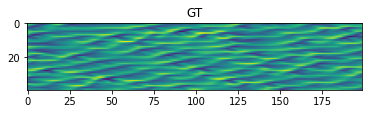

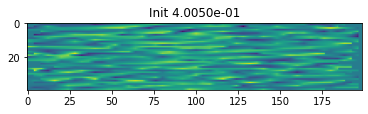

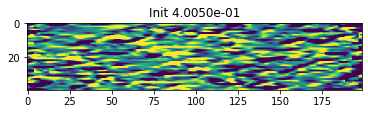

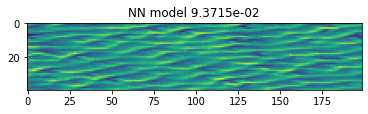

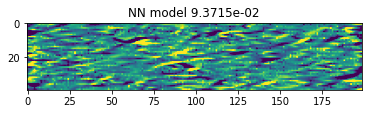

In [0]:
## Visualisation
idxTr = np.random.permutation(y_train.shape[0])[0:2]
idxTt = np.random.permutation(y_test.shape[0])[0:2]

plt.figure(1)
#plt.subplot(3,2,1)
plt.imshow(x_test[idxTt[0],:,:].squeeze())
plt.title('GT')

#plt.subplot(3,2,3)
plt.figure(2)
plt.imshow(x_test_Init[idxTt[0],:,:].squeeze())
plt.title('Init %.4e'%np.mean( (x_test_Init[idxTt[0],:,:]-x_test[idxTt[0],:,:])**2 ))

#plt.subplot(3,2,4)
plt.figure(3)
plt.imshow(x_test_Init[idxTt[0],:,:].squeeze()-x_test[idxTt[0],:,:].squeeze(),vmin=-0.5,vmax=0.5)
plt.title('Init %.4e'%np.mean( (x_test_Init[idxTt[0],:,:]-x_test[idxTt[0],:,:])**2 ))

#plt.subplot(3,2,5)
plt.figure(4)
plt.imshow(y_test[idxTt[0],:,:].squeeze())
plt.title('NN model %.4e'%np.mean( (y_test[idxTt[0],:,:]-x_test[idxTt[0],:,:])**2 ))

#plt.subplot(3,2,6)
plt.figure(5)
plt.imshow(y_test[idxTt[0],:,:].squeeze()-x_test[idxTt[0],:,:].squeeze(),vmin=-0.5,vmax=0.5)
plt.title('NN model %.4e'%np.mean( (y_test[idxTt[0],:,:]-x_test[idxTt[0],:,:])**2 ))



# 4DVar Assimilsation in pytorch

In [0]:
test_dataset         = torch.utils.data.TensorDataset(torch.Tensor(x_test_Init),torch.Tensor(x_test_obs),torch.Tensor(mask_test),torch.Tensor(x_test)) # create your datset

dataloaders = {
    'dataset': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
}            
dataset_sizes = {'dataset': len(test_dataset)}

In [0]:
comptUpdate = 1
iterInit    = 0
iterStateUpdate = 250 
NIterGrad       = 20000
modIter         = 100
delta           = 1e4 
alpha           = 1e0* np.array([.01,0.99])

# Iterate over data.
#for inputs_ in dataloaders[phase]:
#    inputs = inputs_[0].to(device)

numData  = 0
compt    = 0
for x_init,x_obs,masks,x_GT in dataloaders['dataset']:
    x_init    = x_init.to(device)
    x_obs     = x_obs.to(device)
    masks     = masks.to(device)
    x_GT      = x_GT.to(device)

    numData +=  x_GT.size(0)

    # initialisation
    xhat = x_init 
    xhat = torch.autograd.Variable(xhat, requires_grad=True)

    # 4DVar assimilation using trained gradient descent
    losses_test = []
    compt_kk = 0
    for kk in range(0,NIterGrad):     
        # AE projection
        x_pred = model.model_AE( xhat )
        
        # dynamical loss
        loss_dyn = torch.mean((xhat - x_pred)**2 )
    
        # observation loss
        loss_obs = torch.sum((xhat - x_obs)**2 * masks) / torch.sum( masks)
    
        ## loss wrt groudn-truth
        loss_GT  = torch.mean((xhat - x_GT)**2)

        # overall loss
        loss = alpha[0] * loss_obs + alpha[1] * loss_dyn 
    
        # compute gradient w.r.t. X and update X
        loss.backward()
        
        #grad_X  = torch.autograd.grad(loss,X_torch,create_graph=True)
        xhat = xhat - delta * xhat.grad.data
        xhat = torch.autograd.Variable(xhat, requires_grad=True)
                                                          
        # other loss types
        dB          = 0
        dT          = xhat.size(2)
        loss_R      = torch.sum( (xhat[:,:,dB:dT-dB] - x_GT[:,:,dB:dT-dB])**2 * masks[:,:,dB:dT-dB] )
        loss_R      = loss_R / torch.sum( masks[:,:,dB:dT-dB] )
        loss_AE_GT  = torch.mean( (model.model_AE(x_GT)[:,:,dB:dT-dB] - x_GT[:,:,dB:dT-dB])**2 )        
        loss_I      = torch.sum( (xhat[:,:,dB:dT-dB] - x_GT[:,:,dB:dT-dB])**2 * (1. - masks[:,:,dB:dT-dB]) )
        loss_I      = loss_I / torch.sum( (1. - masks[:,:,dB:dT-dB]) )

        # evaluate and store losses
        if( np.mod(kk,modIter) == 0 ):  
            # store as np
            if( compt_kk == 0 ):
                losses_test = torch.cat( (loss_GT.view(1,1),loss_dyn.view(1,1),loss_obs.view(1,1),loss_R.view(1,1),loss_I.view(1,1)), dim = 1 ).cpu().detach().numpy()                                
            else:
                losses_test = np.concatenate( (losses_test,torch.cat( (loss_GT.view(1,1),loss_dyn.view(1,1),loss_obs.view(1,1),loss_R.view(1,1),loss_I.view(1,1)), dim = 1 ).cpu().detach().numpy()) , axis = 0)
            compt_kk += 1
    if compt == 0 :
        loss4DVar = x_GT.size(0) * losses_test
    else :
        loss4DVar = loss4DVar + x_GT.size(0) * losses_test
    compt += 1
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

loss4DVar = stdTr**2 * loss4DVar / numData
                            
print('..........................................')
print('.....')
print('.....')
print('')
for kk in range(0,loss4DVar.shape[0]):
    print('..... Loss Grad Descent %d:  GT %.6e   ---  dyn %.6e   ---  obs %.6e   ---  GT-R %.6e    ---  GT-I %.6e'%(kk*modIter,loss4DVar[kk,0],loss4DVar[kk,1],loss4DVar[kk,2],loss4DVar[kk,3],loss4DVar[kk,4]) )
